# 3D (x-y-t) field inference: alpha sensitivity

We start from a flow field generated with `drifter_3D.ipynb` and modify rescale the flow amplitude to change the value of the $\alpha=U\lambda_t/\lambda_s$

In [3]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt
%matplotlib inline

import corner
import arviz as az

import nwatools.stats as st
colors = st.colors
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


/home1/datawork/aponte/code/pynsitu/pynsitu/__init__.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  hour = Timedelta("1H")
ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


In [4]:
# actually run production inferences
#prod=True
prod=False

local_cluster = not prod
#local_cluster = True # dev
if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=4)

client = Client(cluster)
client

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-message

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39864,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:37171,Total threads: 7
Dashboard: http://127.0.0.1:52796/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:47201,


## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [5]:
# flow case
U = "0.1"
case = "3D_matern32_iso_matern12_pp_r0.0_u"+U

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference
no_space = False
#no_space = True # ! required to be run if time only reference are necessary !
traj_decorrelation = False  # artificially decorrelate different moorings/drifters
#traj_decorrelation = True  # artificially decorrelate different moorings/drifters
if no_space:
    # makes little sense otherwise
    parameter_eta_formulation = True
    traj_decorrelation = True
assert not no_time, "need to implement decorrelation across time"

# number of points used for inference#
Nxy, Nt = 1, 50
#Nxy, Nt = 2, 50
#Nxy, Nt = 5, 50
#Nxy, Nt = 10, 50

# number of ensembles
#Ne = 5 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms

# flow scales
flow_scales = [.5, 1., 2., 3.]
#flow_scales = np.arange(.1, 5., .2)
#flow_scales = np.arange(.1, 2., .5)

burn = 500 # number of samples to drop (burning)

### prepare inference

In [6]:
dsf, covfunc, covparams, labels = st.prepare_inference(
    data_dir, case,
    uv, no_time, no_space,
    parameter_eta_formulation, traj_decorrelation,
)
flow_attrs = dict(**dsf.attrs)

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


U 0.1
amplitude0 5.773502691896257
amplitude1 0.0
cov_t matern12
cov_x matern32_iso
cov_y matern32_iso
eta 5.773502691896257
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
noise 0.0
pp_ratio 0.0
dx 10.0
dy 10.0
nu_space 1.5
nu_time 0.5
amplitude_deficit 0.8924557740934536


---

## run/load inferences

### mooring inference

In [7]:
def get_file_path_mooring(flow_scale, Nxy, dx, no_space, traj_decorrelation):
    nc = os.path.join(data_dir, case+f"_moorings_fs{flow_scale:.2f}_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if no_space:
        nc = nc.replace(".nc", f"_nospace.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    return nc
    
def run_inferences_mooring(flow_scale):

    nc = get_file_path_mooring(flow_scale, Nxy, dx, no_space, traj_decorrelation)

    # note: does not overwrite
    if prod and not os.path.isfile(nc):
        ds = st.run_mooring_ensembles(
            Ne, dsf, 
            covparams, covfunc, labels, (Nt, Nxy), 
            noise, dx=dx,
            flow_scale=flow_scale,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        
    return ds

def load_inferences_mooring(no_space):

    Dm = []
    for flow_scale in flow_scales:
        trajd = traj_decorrelation
        if no_space:
            trajd = True
        nc = get_file_path_mooring(flow_scale, Nxy, dx, no_space, trajd)
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        Dm.append(ds)
        
    return Dm

In [8]:
Dm = []
for f in tqdm(flow_scales):
    Dm.append(run_inferences_mooring(f))

100%|██████████| 4/4 [00:00<00:00, 10.90it/s]



### drifter inference

- Lagrangian simulation
- actual inference


In [7]:
## setup parcels

def run_lagrangian_simulation(flow_scale, overwrite=False):

    import xarray as xr
    from datetime import timedelta
    from parcels import (
        AdvectionRK4,
        FieldSet,
        JITParticle,
        ParticleSet,
        Variable,
        plotTrajectoriesFile,
    )
        
    # output file
    nc_file = os.path.join(data_dir, case+f"_drifters_fs{flow_scale:.2f}.nc")
    if os.path.isfile(nc_file) and not overwrite:
        return

    #with dask.config.set(scheduler="threads"):    
    # assemble Field set
    flow_file = os.path.join(data_dir, case+"_flow.zarr")
    ds = xr.open_zarr(os.path.join(data_dir, flow_file), decode_times=False)
    ds["U"] = ds["U"]*flow_scale
    ds["V"] = ds["V"]*flow_scale
    ds["x"] = ds["x"]*1e3 # rescale in m
    ds["y"] = ds["y"]*1e3 # rescale in m
    dx = float(ds["x"][1]-ds["x"][0])
    dy = float(ds["y"][1]-ds["y"][0])
    ds = ds.rename(x="lon", y="lat")
    ds["time"] = ds["time"]*day # rescale in seconds
    ds["time"].attrs.update(units="seconds")

    # define bounds to kill trajectories
    nb = 2
    bounds = (float(ds["lon"].values[0])  + nb*dx,
              float(ds["lon"].values[-1]) - nb*dx,
              float(ds["lat"].values[0])  + nb*dy,
              float(ds["lat"].values[-1]) - nb*dy,
    )

    # generate fieldset
    fieldset = FieldSet.from_xarray_dataset(
        ds,
        variables=dict(U="U", V="V"),
        dimensions=dict(lon="lon", lat="lat", time="time"),                         
        mesh="flat",
    )

    # create Particle set
    _ds = ds.isel(lon=slice(10,-10,1), lat=slice(10,-10,1)) # coarse grid
    #_ds = ds.isel(lon=slice(10,-10,10), lat=slice(10,-10,10))
    x0 = (_ds.lon   + _ds.lat*0).values.flatten()
    y0 = (_ds.lon*0 + _ds.lat  ).values.flatten()

    pset = ParticleSet.from_list(
        fieldset=fieldset,  # the fields on which the particles are advected
        pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
        lon=x0,  # a vector of release longitudes
        lat=y0,  # a vector of release latitudes
        #time=t0,
    )

    output_file = pset.ParticleFile(
        name=nc_file,  # the file name
        outputdt=timedelta(hours=1),  # the time step of the outputs
    )

    Tmax = np.floor(float(max(ds["time"]/day)))

    # deal with boundaries
    fieldset.add_constant('b0', bounds[0])
    fieldset.add_constant('b1', bounds[1])
    fieldset.add_constant('b2', bounds[2])
    fieldset.add_constant('b3', bounds[3])
    def StopParticle(particle, fieldset, time):
        # https://github.com/OceanParcels/parcels/blob/bf98c977a260afd86e91ce7af8f3af7dfef90edf/docs/examples/example_stommel.py#L86
        # https://docs.oceanparcels.org/en/latest/reference/particles.html#module-parcels.particle
        #if (particle.lon < bounds[0]) or (particle.lon > bounds[1]) or (particle.lat < bounds[2]) or (particle.lat > bounds[2]):
        if (particle.lon < fieldset.b0) or (particle.lon > fieldset.b1) \
            or (particle.lat < fieldset.b2) or (particle.lat > fieldset.b3):
            particle.delete()
            
    pset.execute(
        AdvectionRK4+pset.Kernel(StopParticle),  # the kernel (which defines how particles move)
        #AdvectionRK4,  # the kernel (which defines how particles move)
        runtime=timedelta(days=Tmax),  # the total length of the run
        dt=timedelta(minutes=30),  # the timestep of the kernel
        #dt=timedelta(minutes=30),  # the timestep of the kernel
        output_file=output_file,
        verbose_progress=False,
    )

    # necessary for older version of parcels (as old as 2.3.0 at least)
    output_file.export()

#### drifter advection

In [9]:
#Can't distribute parcels simulation for some reason
if prod:
    for f in flow_scales:
        print(f" start {f}")
        run_lagrangian_simulation(f, overwrite=False)
        print(f" end {f}")

#### inference

In [9]:
def get_file_path_drifter(flow_scale, Nxy, dx, no_space, traj_decorrelation):
    nc = os.path.join(data_dir, case+f"_drifters_fs{flow_scale:.2f}_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if no_space:
        nc = nc.replace(".nc", f"_nospace.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    return nc

def run_inferences_drifter(flow_scale):

    nc = get_file_path_drifter(flow_scale, Nxy, dx, no_space, traj_decorrelation)

    # note: does not overwrite
    if prod and not os.path.isfile(nc):
        ds = st.run_drifter_ensembles(
            data_dir, case, Ne,
            covparams, covfunc, labels, (Nt, Nxy),
            noise, 
            dx=dx, 
            flow_scale=flow_scale,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        
    return ds

def load_inferences_drifter(no_space):

    Dr = []
    for flow_scale in flow_scales:
        trajd = traj_decorrelation
        if no_space:
            trajd = True
        nc = get_file_path_drifter(flow_scale, Nxy, dx, no_space, trajd)
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        Dr.append(ds)
        
    return Dr

In [10]:
Dr = []
for f in tqdm(flow_scales):
    Dr.append(run_inferences_drifter(f))

100%|██████████| 4/4 [00:00<00:00, 13.20it/s]


---
## concatenate and inspect

In [11]:
def _pprocess(ds, λx=None):
    ds = ds.copy()
    for v in ["true_parameters", "flow_scale", "survival_rate", "lower", "upper"]:
        if v in ds:
            ds[v] = ds[v].isel(ensemble=0)
    ds["U"] = float(U) * ds.flow_scale * flow_attrs["amplitude_deficit"]
    λt = float(ds["true_parameters"].sel(parameter="λt"))
    if λx is None:
        λx = float(ds["true_parameters"].sel(parameter="λx"))
    ds = (ds
      .assign_coords(α = ds["U"] * λt*day/(λx*1e3))
      .set_coords("true_parameters")
    )
    ds.attrs.update(**flow_attrs)
    return ds

dsm = xr.concat([_pprocess(d) for d in Dm], "flow_scale")
dsr = xr.concat([_pprocess(d) for d in Dr], "flow_scale")

In [12]:
# purely temporal inference
Dm_nospace = load_inferences_mooring(True)
Dr_nospace = load_inferences_drifter(True)

dsm_nospace = xr.concat([_pprocess(d, λx=flow_attrs["lambda_x"]) for d in Dm_nospace], "flow_scale")
dsr_nospace = xr.concat([_pprocess(d, λx=flow_attrs["lambda_x"]) for d in Dr_nospace], "flow_scale")

In [13]:
bounds = dict(
    σ=(-.01,.1),
    γ=(-.01,.2),
    λx=(-50,1100),
    λt=(-1,30),
)
# common kwargs
kw = dict(x="α", x_off=.055, x_width=0.04, bounds=bounds)

{'U': 0.1,
 'amplitude0': 5.773502691896257,
 'amplitude1': 0.0,
 'cov_t': 'matern12',
 'cov_x': 'matern32_iso',
 'cov_y': 'matern32_iso',
 'eta': 5.773502691896257,
 'kind': 'pp',
 'lambda_t': 5,
 'lambda_x': 100,
 'lambda_y': 100,
 'noise': 0.0,
 'pp_ratio': 0.0,
 'dx': 10.0,
 'dy': 10.0,
 'nu_space': 1.5,
 'nu_time': 0.5,
 'amplitude_deficit': 0.8924557740934536}

In [31]:
def add_nospace(ds, c, axes):
    
    for p, k in zip(dsm.parameter.values, axes):
        ax = axes[k]
        if p=="γ":
            da = ds["MAP"].sel(parameter="u").median("ensemble")
            _gamma = np.sqrt( (flow_attrs["nu_space"]-1)/flow_attrs["nu_space"] ) * da
            # need to recompose gamma = eta / lambdax = np.sqrt((ν-1)/ν) * U
            ax.plot(da["α"], _gamma, color=c, ls="--")
        if p=="λt":
            da = ds["MAP"].sel(parameter=p) #.median("ensemble")
            #ax.plot(da["α"], da, color=c, ls="--")
            st._shadeplot(ax, da, da["α"], alpha=0.3, color=c)

/home1/datawork/aponte/code/nwa/nwatools/stats.py:1711: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend([b0, b1, h_truth], ['moorings', 'drifters', 'truth'], loc='upper right')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/alpha_MAP.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/alpha_MAP.png .


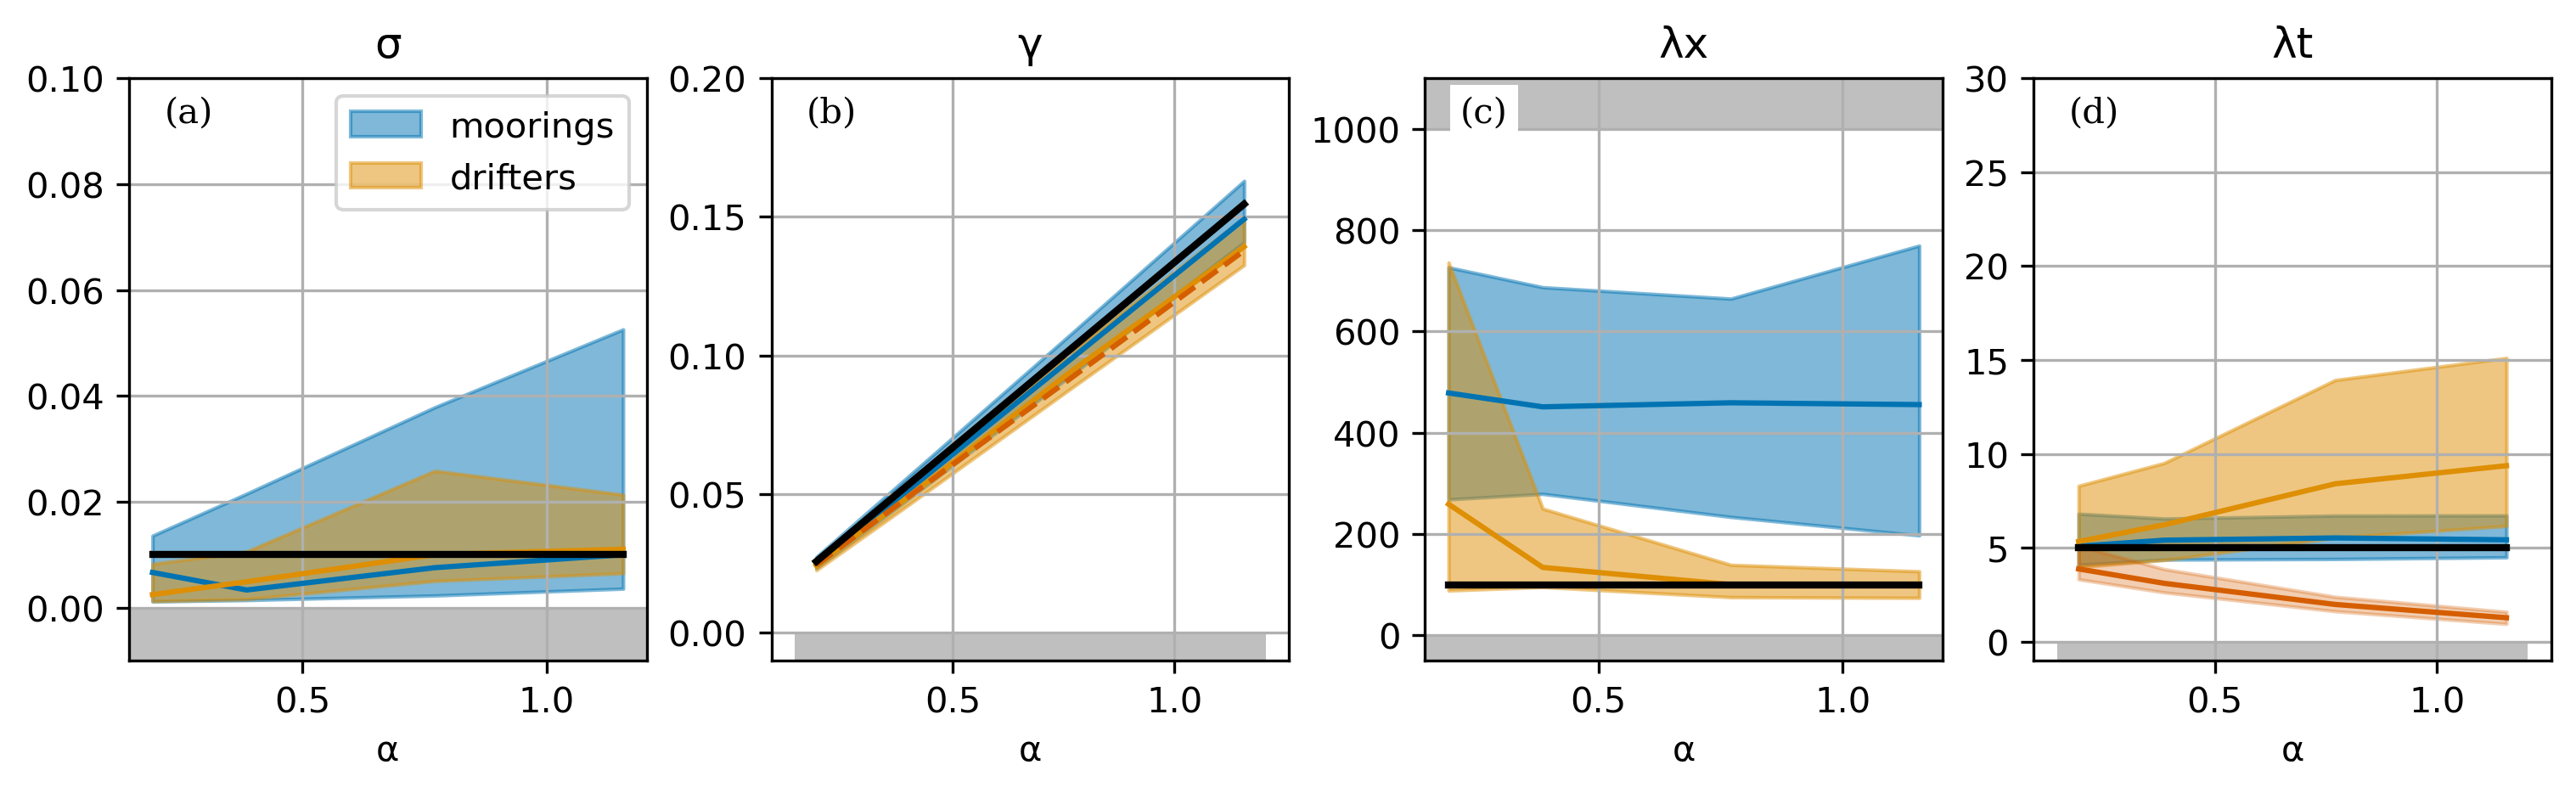

In [32]:
fig, axes = st.plot_sensitivity_combined(dsm, dsr, alpha=0.5, **kw)

#add_nospace(dsr_nospace, colors["dr"], axes)
add_nospace(dsr_nospace, st.cpal[3], axes)
#add_nospace(dsm_nospace, colors["mo"], axes)

st.label_and_print(fig, axes, "alpha_MAP")

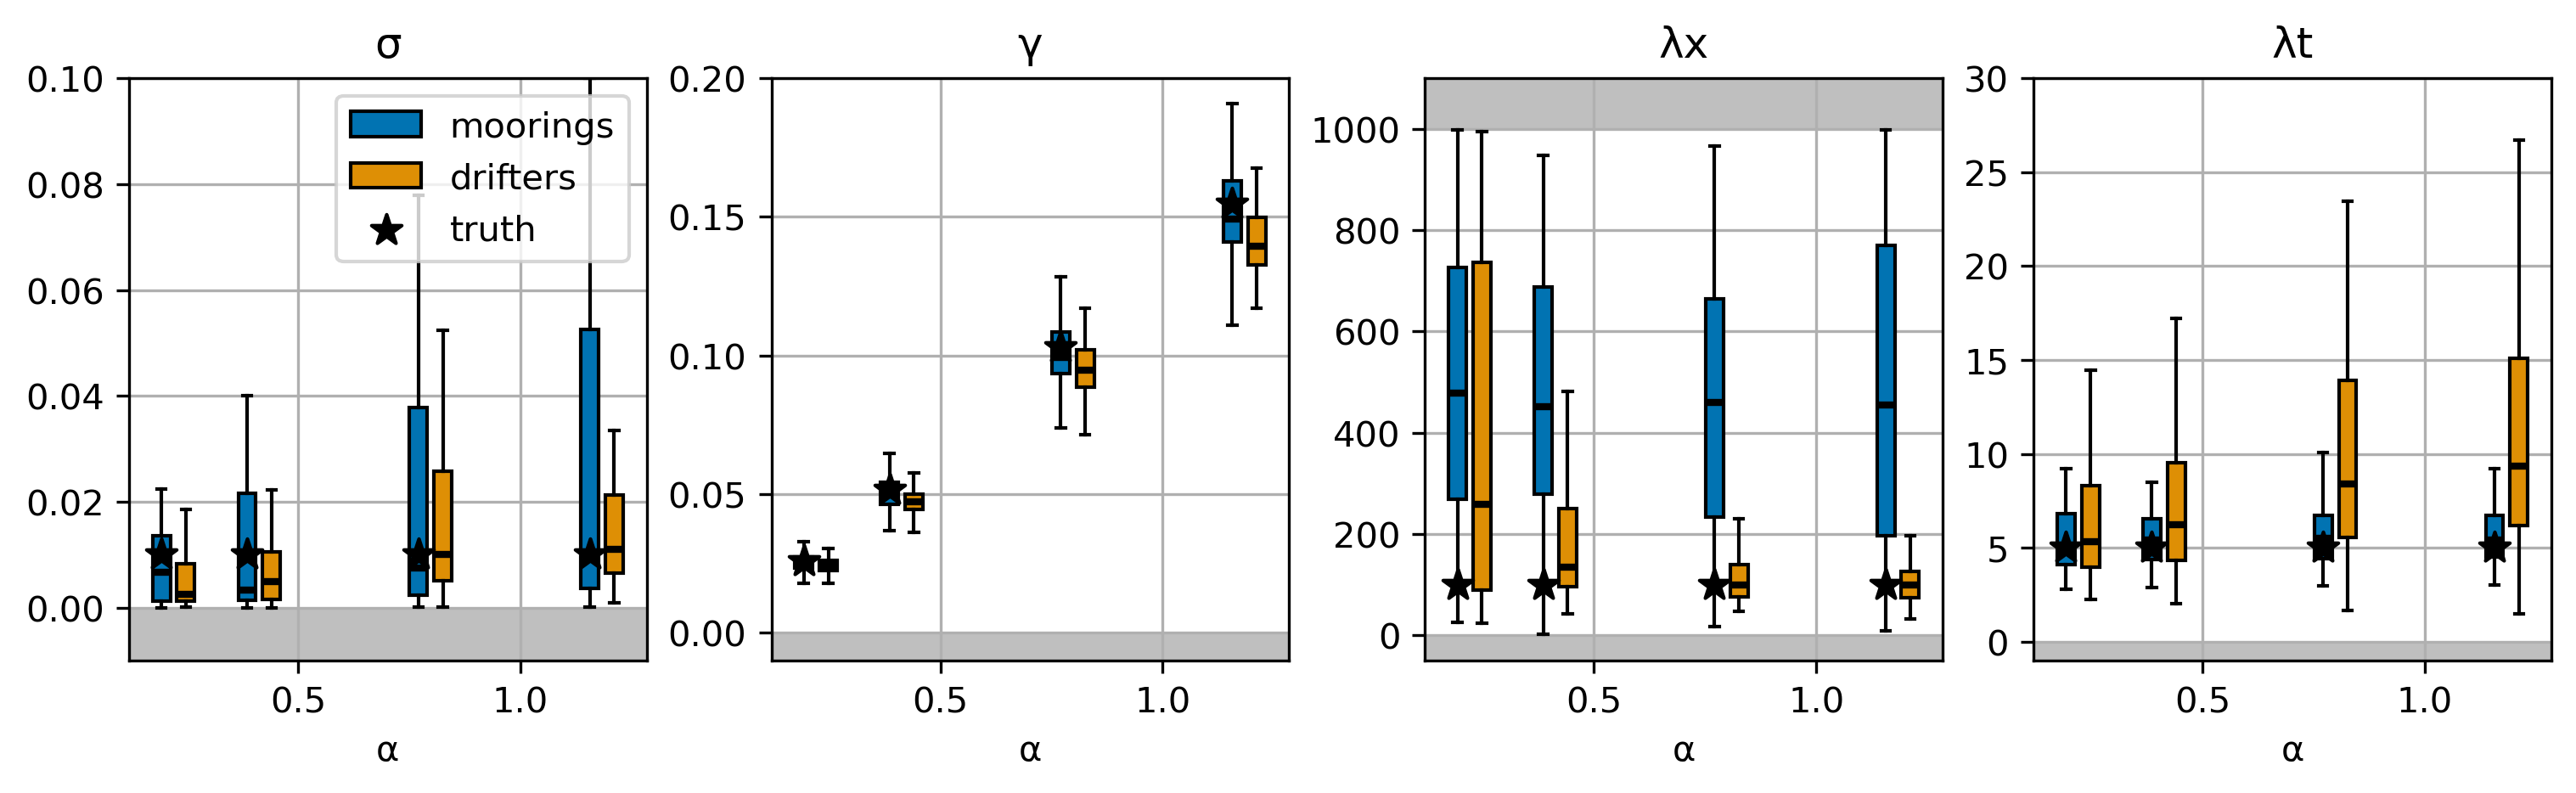

In [16]:
fig, axes = st.plot_sensitivity_combined(dsm, dsr, type="boxplot", **kw)

/home1/datawork/aponte/code/nwa/nwatools/stats.py:1737: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend([b0, b1], [label, 'truth'], loc='upper right')


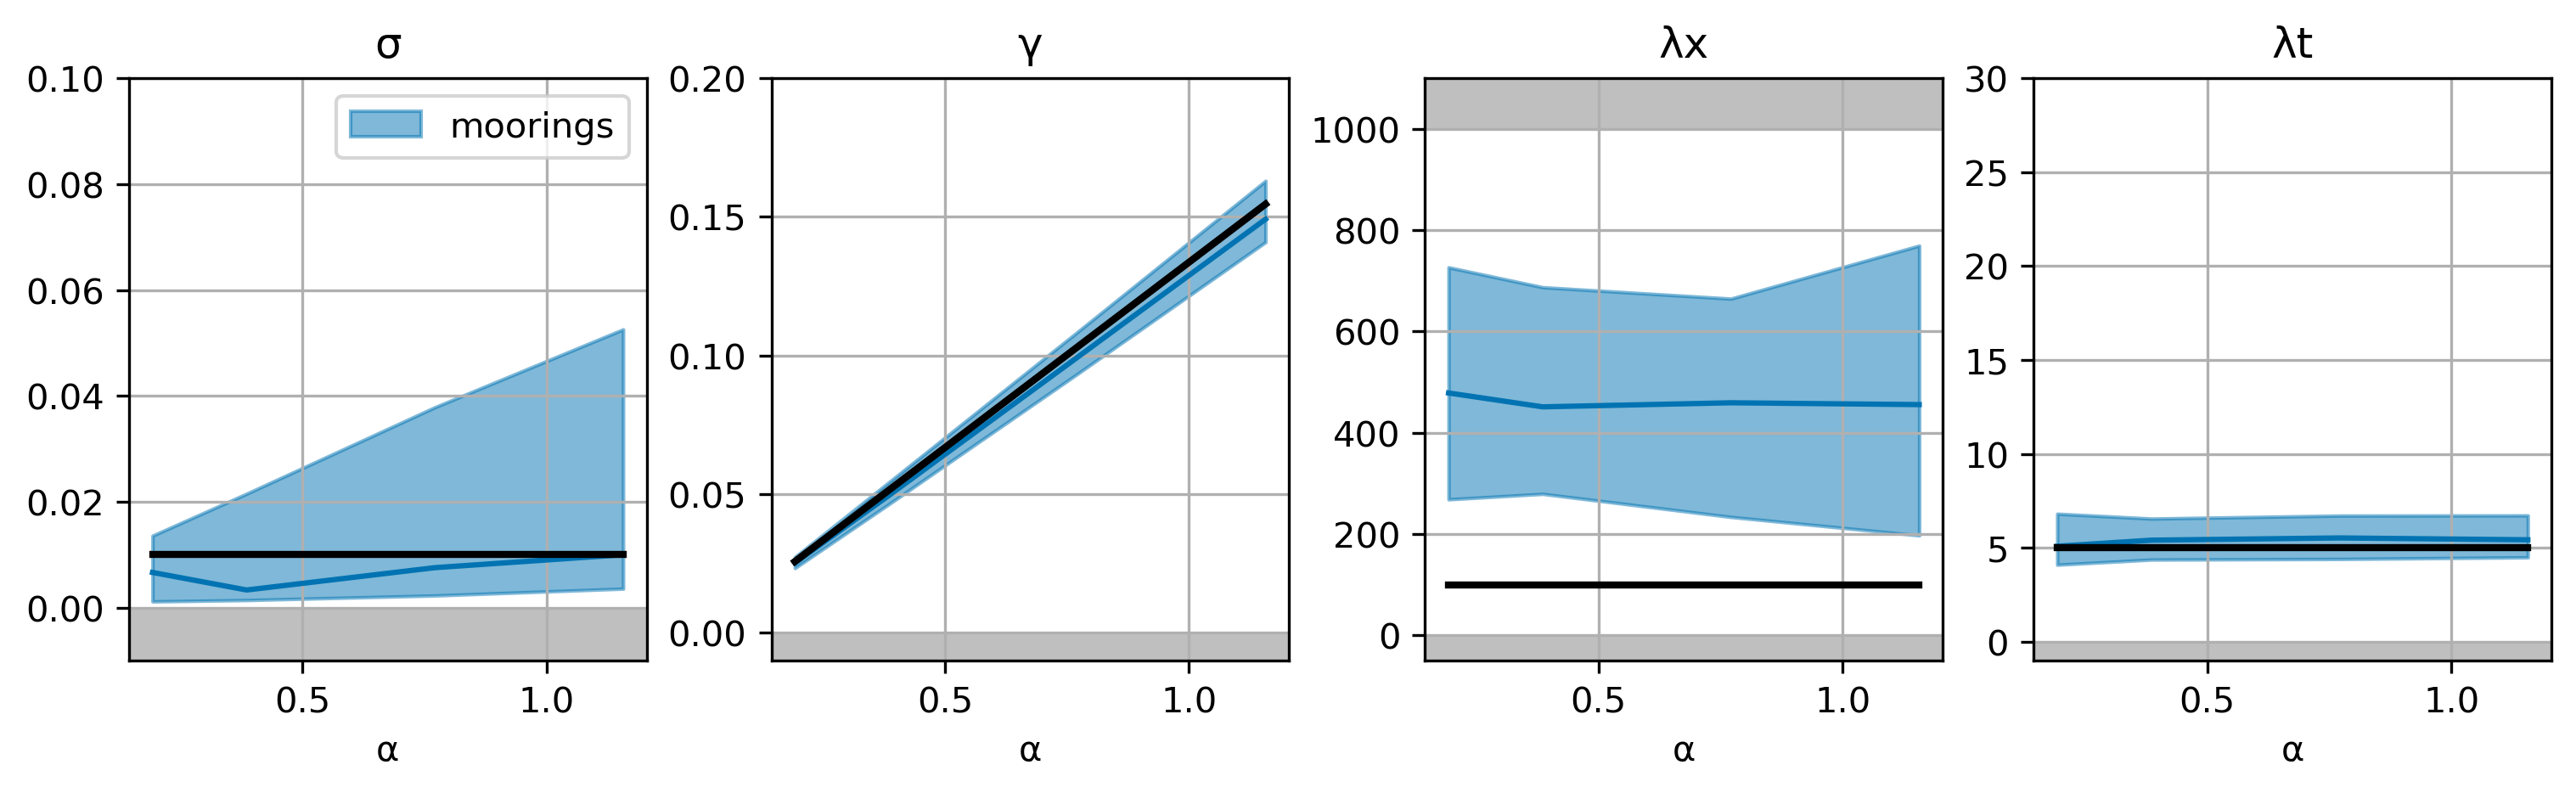

In [20]:
fig, axes = st.plot_sensitivity_combined(
    dsm, None, label="moorings", alpha=0.5, **kw,
)

/home1/datawork/aponte/code/nwa/nwatools/stats.py:1737: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend([b0, b1], [label, 'truth'], loc='upper right')


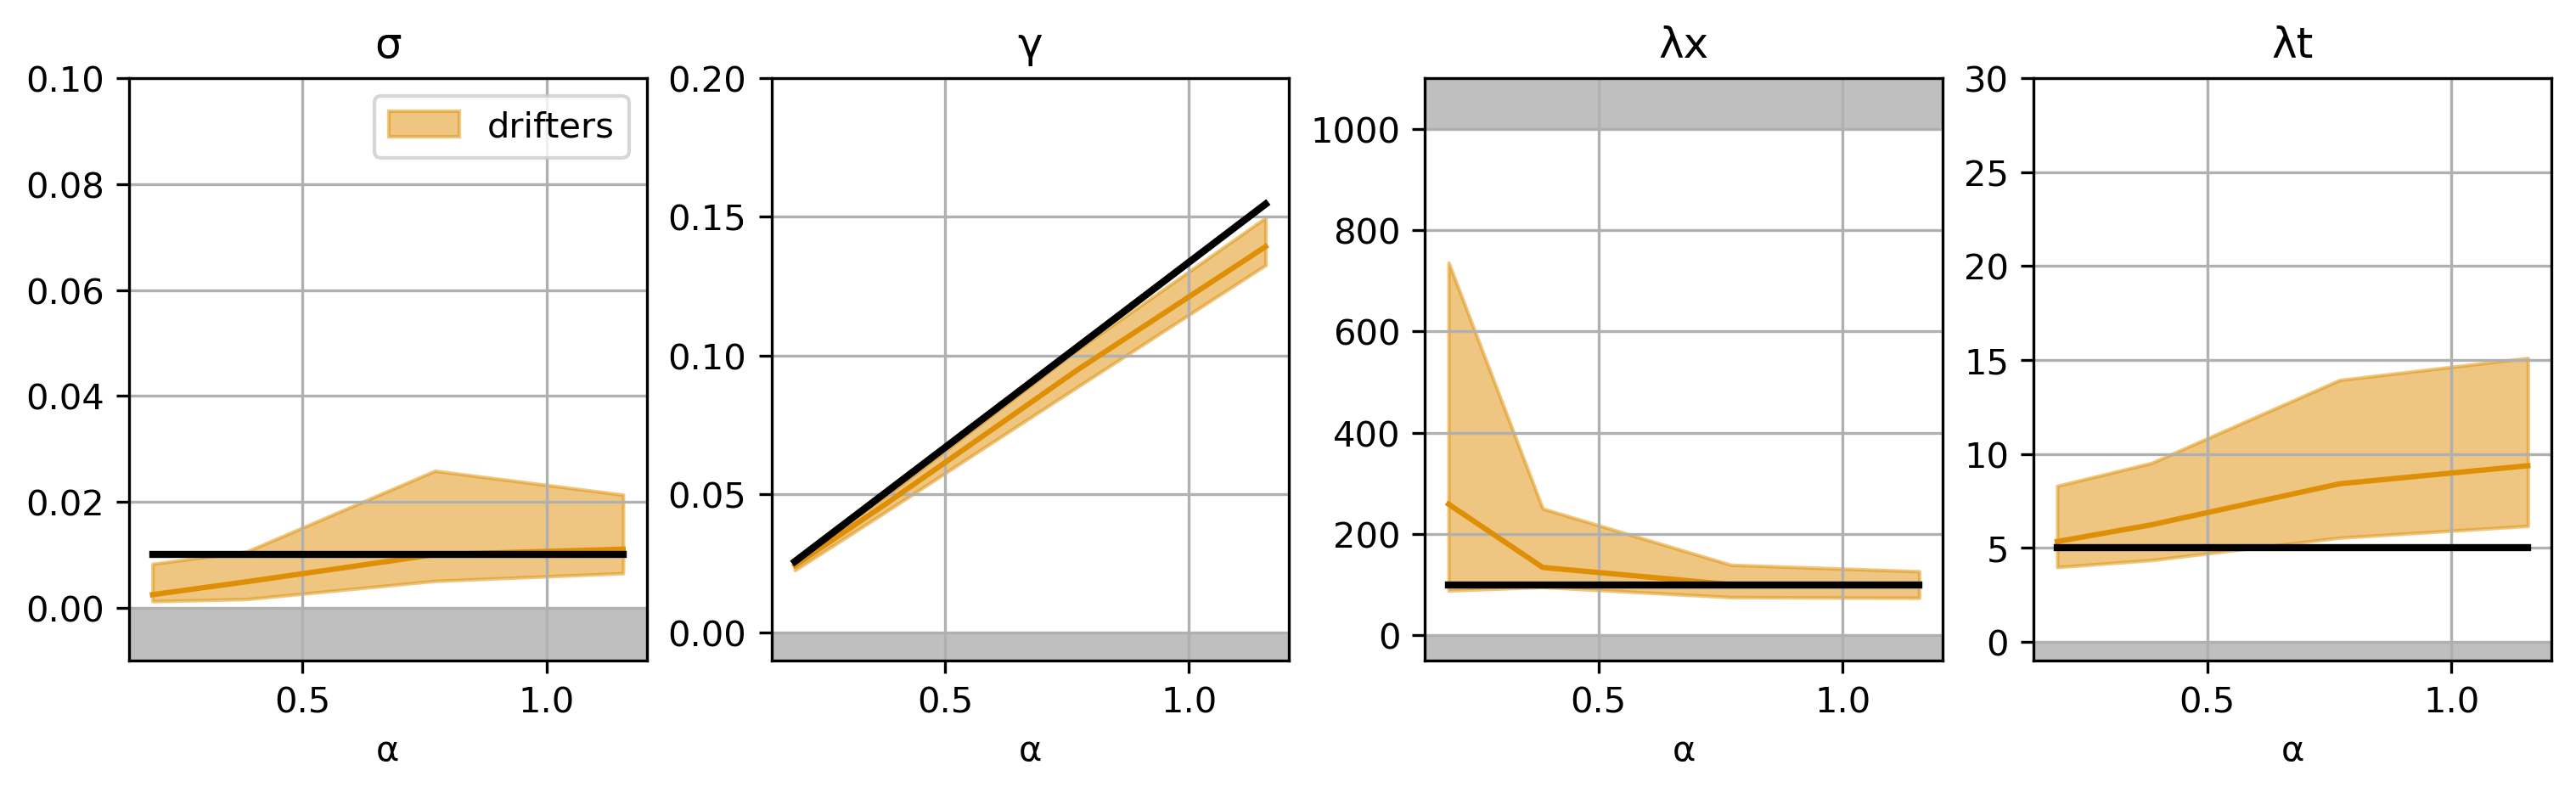

In [21]:
fig, axes = st.plot_sensitivity_combined(
    dsr, None, label="drifters", c=colors["dr"], alpha=0.5, **kw,
)

---
## survival rate

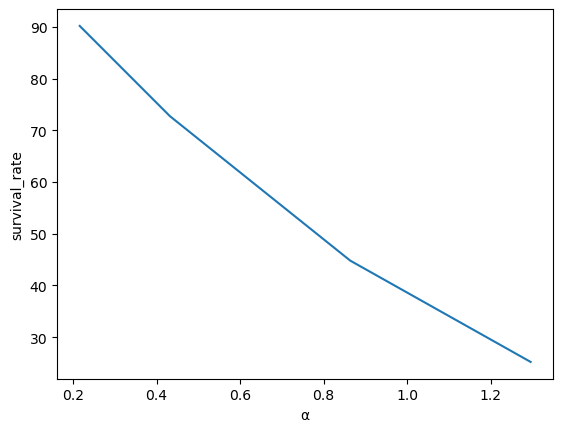

In [34]:
#fig, ax = plt.subplots(1,1)
dsr["survival_rate"].plot(x="α")
#ax.grid()

----

In [11]:
cluster.close()